In [1]:
%load_ext autoreload
%autoreload 2
from final_project.models import run_model
from final_project.models import save_model_pkl
from final_project.models import load_model
from final_project.models import plot_frequencies
from final_project import builder
from final_project.loader import get_df
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
master_df = get_df(year="2018")
master_df = master_df.sample(n=100000, random_state=150)
# builder.runEDA(master_df)
master_df = builder.columnManager(master_df)
master_df = builder.encodeFrame(master_df)
master_df = master_df[["date_sin","date_cos","ArrDel15","month_sin","month_cos","DistanceGroup","WeatherDelay","NASDelay","SecurityDelay"]]

         ArrDel15  DistanceGroup  CarrierDelay  WeatherDelay  NASDelay  \
1812937       0.0              4           0.0           0.0       0.0   
5104019       1.0              5           8.0           0.0       8.0   
27120         1.0              4          42.0           0.0      40.0   
5206655       0.0              2           0.0           0.0       0.0   
1662881       0.0              2           0.0           0.0       0.0   

         SecurityDelay  LateAircraftDelay  date_sin  date_cos  month_sin  ...  \
1812937            0.0                0.0  0.724793  0.688967  -0.500000  ...   
5104019            0.0                0.0 -0.571268  0.820763   0.866025  ...   
27120              0.0                6.0  0.998717 -0.050649  -0.866025  ...   
5206655            0.0                0.0  0.848644  0.528964   0.866025  ...   
1662881            0.0                0.0 -0.848644  0.528964  -1.000000  ...   

         Dest_UIN  Dest_USA  Dest_VEL  Dest_VLD  Dest_VPS  Dest_WRG 

# samples: 100000
train:
 - Number of features:  8
 - Number of samples:  40000
[32438  7562]


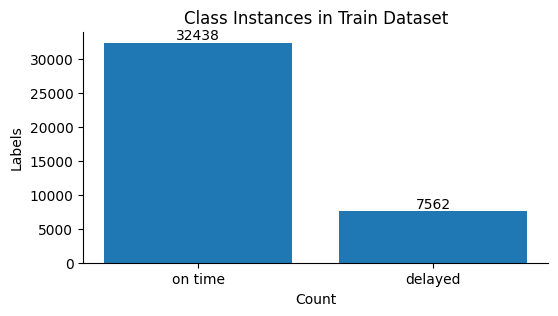


test:
 - Number of features:  8
 - Number of samples:  30000
[24224  5776]


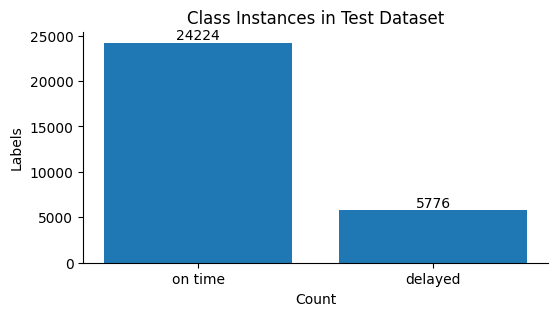


validation:
 - Number of features:  8
 - Number of samples:  30000
[24256  5744]


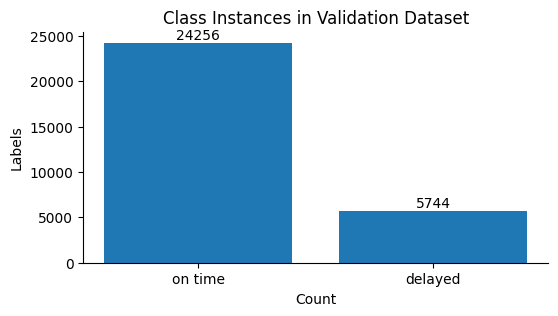

In [3]:
'''
process data for training, split into test/train/validation
'''
X = master_df.drop(columns=["ArrDel15"])
y = master_df[["ArrDel15"]]
y = y.ArrDel15.ravel() # flatten
print("# samples:", y.shape[0])

# split into train and test/validation (which is then split in next line)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y,
                                                    test_size=0.6,
                                                    random_state=150)

# create validation and test sets each 15% of total data
X_test, X_validation, y_test, y_validation = train_test_split(X_test_val, y_test_val,
                                                    test_size=0.5,
                                                    random_state=150)
data = {"train": (X_train,y_train), "test":(X_test,y_test), "validation": (X_validation,y_validation)}

# number of classes, number of instances in each class
for each in data.keys():
    print(f"{each}:")
    print(" - Number of features: ", len(data[each][0].columns))
    print(" - Number of samples: ", len(data[each][0]))
    unique, counts = np.unique(data[each][1], return_counts=True)
    plot_frequencies(each, (unique, counts))
    print()

In [4]:
# create train numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_validation = X_validation.to_numpy()

# convert to tensors
X_train, y_train, X_test, y_test, X_validation, y_validation = map(
    torch.tensor, (X_train, y_train, X_test, y_test, X_validation, y_validation)
)

In [5]:
# create dataset and dataloader
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
valid_ds = TensorDataset(X_validation, y_validation)
num_features=X_train.shape[1] 

100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

best loss:  0.2778100073337555
+---------------------------+---------+
| Hyperparameter            |   Value |
+===========================+=========+
| Best batch size:          |   64    |
+---------------------------+---------+
| Best epoch:               |   10    |
+---------------------------+---------+
| Best learning rate:       |    0.01 |
+---------------------------+---------+
| Best num nodes:           |    2    |
+---------------------------+---------+
| Best num layers:          |    1    |
+---------------------------+---------+
| Best momentum:            |    0    |
+---------------------------+---------+
| Best weight decay:        |    0    |
+---------------------------+---------+
| Best dropout probability: |    0    |
+---------------------------+---------+


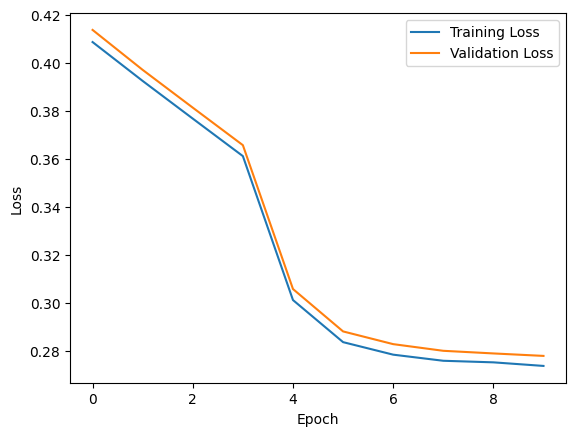

Evaluating **train** dataset:


100%|██████████| 625/625 [00:00<00:00, 3510.05it/s]


Mean Accuracy: 91.590
Mean per-class accuracy:
  on time: 100.000%
  delayed: 55.514%
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     32438
         1.0       1.00      0.56      0.71      7562

    accuracy                           0.92     40000
   macro avg       0.95      0.78      0.83     40000
weighted avg       0.92      0.92      0.91     40000

[[32438     0]
 [ 3364  4198]]

Evaluating **test** dataset:


100%|██████████| 469/469 [00:00<00:00, 4464.07it/s]


Mean Accuracy: 91.200
Mean per-class accuracy:
  on time: 100.000%
  delayed: 54.294%
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95     24224
         1.0       1.00      0.54      0.70      5776

    accuracy                           0.91     30000
   macro avg       0.95      0.77      0.83     30000
weighted avg       0.92      0.91      0.90     30000

[[24224     0]
 [ 2640  3136]]

Evaluating **validation** dataset:


100%|██████████| 469/469 [00:00<00:00, 4715.75it/s]


Mean Accuracy: 91.373
Mean per-class accuracy:
  on time: 100.000%
  delayed: 54.944%
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95     24256
         1.0       1.00      0.55      0.71      5744

    accuracy                           0.91     30000
   macro avg       0.95      0.77      0.83     30000
weighted avg       0.92      0.91      0.90     30000

[[24256     0]
 [ 2588  3156]]



In [6]:
params = {"bs":(64,),
        "epoch":(10,),
        "learning_rate":(.01,),
        "momentum":(0,),
        "weight_decay":(0,),
        "activation_fn": nn.ReLU,
        "dropout_prob": (0,),
        "num_layers": (1,),
        "num_nodes": (2,)}
best_model_params = run_model(param_dict=params, 
                  train_ds=train_ds, 
                  test_ds=test_ds, 
                  valid_ds=valid_ds,
                  num_features=num_features
                  )

In [7]:
save_model_pkl(best_model_params)

In [8]:
model = load_model("../models/1_2_state_dict.pkl")

In [ ]:
model.predict(train_ds)